In [45]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#### Нам необходмо спрогнозировать показатель Y --- есть ли у клиента срочный вклад (0 - нет, 1 - да)

### 1. Предобработка данных 

In [2]:
# Подгрузим набор по клиентам банка с содержанием (41188 записей с 21 полей)
data = pd.read_csv('data.csv', header=0, sep = ',')
data = data.dropna()
print(data.shape)
print(list(data.columns))

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [4]:
# Сократим колличество категорий , чтобы сделать модель лучше, нужно сократить категории:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [5]:
# Сгрупируем Basic, в который войдут '4y,6y, 9y'
data['education']=np.where(data['education'] == 'basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] == 'basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] == 'basic.4y', 'Basic', data['education'])

In [6]:
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

### 2. Исследуем данные

In [7]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

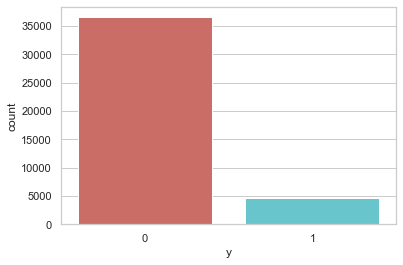

In [8]:
sns.countplot(x='y', data=data, palette = 'hls')
plt.show()

In [9]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is(без вклада)", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of no subscription is (с вкадом)", pct_of_sub*100)

# Видим что классы не сбалансированным, необходимо провести доп.исседование для балансировки;

percentage of no subscription is(без вклада) 88.73458288821988
percentage of no subscription is (с вкадом) 11.265417111780131


Рассмотрим новые наблюдения:

    1) Средний возраст клиентов, открывших вклад, выше среднего возраста тех, кто этого не сделал.
 
    2) Количество дней с последнего контакта с клиентом по понятным причинам меньше у клиентов, открывших депозит. А чем она меньше, тем лучше запомнился последний звонок, а значит, выше шанс открытия счёта.

Чтобы чётче представлять данные, рассчитаем категориальное среднее других категориальных переменных.

Возьмём образование и семейное положение.

In [11]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [12]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [13]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


### 3. Визуализируем исследуемые объекты

Text(0.5, 0, 'Frequency of Purchase')

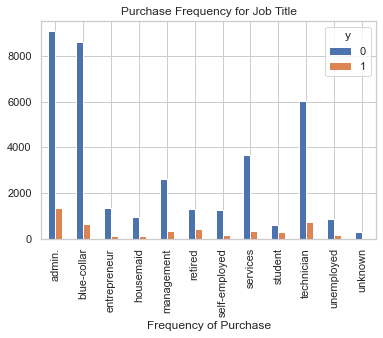

In [14]:
pd.crosstab(data.job, data.y).plot(kind = 'bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.xlabel('Frequency of Purchase')
# Открытие депозита очень сильно зависит от должности того или иного клиента, поэтому нужно
# Включим данный параметр

Text(0, 0.5, 'Proportion of Customers')

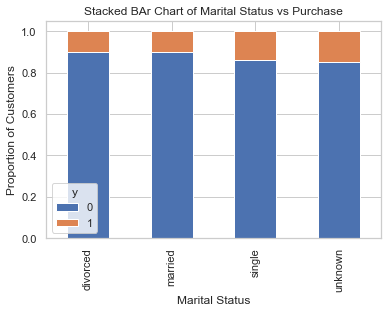

In [15]:
table=pd.crosstab(data.marital, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked BAr Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
#Семейное положение не является сильным фактором, для прогнозирование; 

Text(0, 0.5, 'Frequency of Purchase')

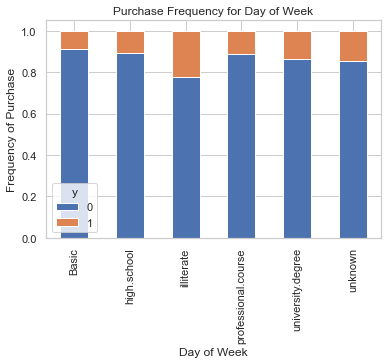

In [16]:
table=pd.crosstab(data.education, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
#Образование является вполне подходящим фактором для прогнозирования;

Text(0.5, 0, 'Frequency of Purchase')

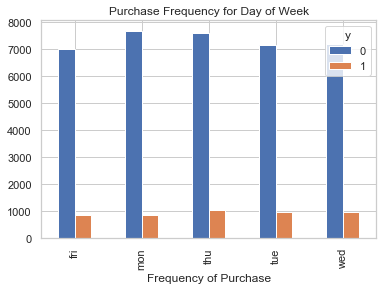

In [17]:
pd.crosstab(data.day_of_week, data.y).plot(kind = 'bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.xlabel('Frequency of Purchase')
#Наличие денег не является;

Text(0.5, 0, 'Frequency of Purchase')

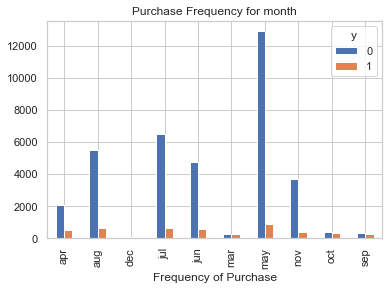

In [18]:
pd.crosstab(data.month, data.y).plot(kind = 'bar')
plt.title('Purchase Frequency for month')
plt.xlabel('Day of Week')
plt.xlabel('Frequency of Purchase')
#Месяц может оказаться хорошим фактором для прогнозирования;

Text(0, 0.5, 'Frequency')

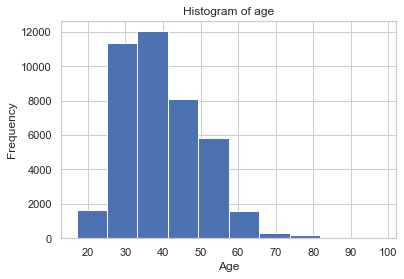

In [19]:
data.age.hist()
plt.title('Histogram of age')
plt.xlabel('Age')
plt.ylabel('Frequency')
# Большинству клиентов банка в наболре даннных от 30 до 40 лет.

Text(0, 0.5, 'Frequency of Purchase')

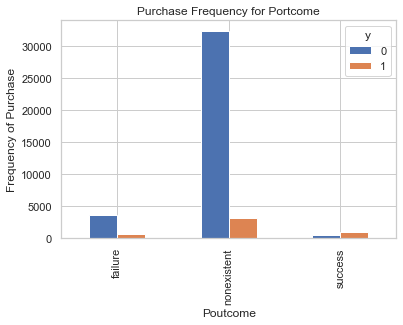

In [20]:
pd.crosstab(data.poutcome, data.y).plot(kind = 'bar')
plt.title('Purchase Frequency for Portcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
# Параметри "Результат" может помочь в прогнозирование;

### 4) Переменные - заглушки(с 0 и 1)

In [21]:
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list, rsuffix='_right')
    data=data1
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [22]:
data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

### 5. Обогатим синтетическими данными через алгоритм SMOTE 

Увиличим данные о клиентахз с помощью алгоритма SMOTE, сам алгоритм генерирует выборки из мирного класса и случайно выбирает наблюдение из близжайших соседей, чтобы создать подобное, но случайно подстроенное наблюдение

In [23]:
X = data_final.loc[:, data_final.columns !='y']
y = data_final.loc[:, data_final.columns =='y']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y =os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['y'])

print("length of oversampled data is", len(os_data_X))
print("Number of no subscription in oversampled data", len(os_data_y[os_data_y['y']==0]))
print("Number of subcription", len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled dat is", len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ", len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is 51134
Number of no subscription in oversampled data 25567
Number of subcription 25567
Proportion of no subscription data in oversampled dat is 0.5
Proportion of subscription data in oversampled data is  0.5


Полученный результат сбалансировал идеально выборку. Стоит отметить, что это только тренировочные данные, тестовые остались без изменений.

### 6. Рекурсивное устранение признаков

Необходимость метода заключается в том, чтобы выбрать лучшие и худшиее признаки, путём отбрасывания признаков и повторение процесса.

In [24]:
data_final_vars = data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE 
logreg = LogisticRegression()
rfe = RFE(estimator=logreg,n_features_to_select= 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

C:\Users\roman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\roman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\roman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\roman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\roman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\roman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[False False False False False False False False False False False False
 False False False False False False False False False False  True  True
  True  True  True  True False  True  True  True False False False  True
  True  True  True  True  True False False False False False False False
 False False False False False  True  True  True  True  True False False
 False]
[34 37 33 39 32 29 28 35 20 36 15  8  9 11 14 40 13 12 19 10 16 17  1  1
  1  1  1  1 41  1  1  1  3  2 42  1  1  1  1  1  1  5  4 21 23 24 25 26
 30 18 22 38 27  1  1  1  1  1  7  6 31]


Метод помог выбрать следующие признаки:['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 'default_no', 'default_unknown','contact_cellular',
'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun','month_mar', 'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"]

In [25]:
cols = ['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 'default_no', 'default_unknown','contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun','month_mar', 'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"]
X = os_data_X[cols]
y = os_data_y['y']

### 7. Реализация модели

In [27]:
import statsmodels.api as sm
logit_models = sm.Logit(y,X)
result = logit_models.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.455664
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.343     
Dependent Variable:   y                 AIC:               46639.8230
Date:                 2023-02-20 14:40  BIC:               46816.6671
No. Observations:     51134             Log-Likelihood:    -23300.   
Df Model:             19                LL-Null:           -35443.   
Df Residuals:         51114             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m             0.1612   0.0082  19.7747 0.0000  0.1452  0.1772
job_blue-collar 

Видно что параметры не имеют существенных отклонений по значению p

### 8. Строим модель логистической регрессии

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\roman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [29]:
# Строим прогноз показателя Y:
y_pred = logreg.predict(X_test)
print('AUC {:.2f}'.format(logreg.score(X_test, y_test)))

AUC 0.87


In [54]:
# Полученный прогноз:
y_pred

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

Точность классификатора составила 0.84, то есть на 84% классификатор правильно соотносит прогнозные значения по классам;

In [44]:
#Расчёт матрицы TP FN TN FP
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[7020  646]
 [1334 6341]]


Из проведённого расчёта видно, что классификатор правильно отобрал TP:7020, FN:6341.

Так же можно заключить, что TN:1334 и FP:646, были соотнесены не верно. 

In [48]:
# Расчитаем точность, полноту, F-меру и параметр носителя:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      7666
           1       0.91      0.83      0.86      7675

    accuracy                           0.87     15341
   macro avg       0.87      0.87      0.87     15341
weighted avg       0.87      0.87      0.87     15341



87% рекламируемых срочных депозитов понравились клиентам;

87% срочных депозитов, предпочтительные клиентами были прорекламированны.

### 9. Строим ROC-Кривую

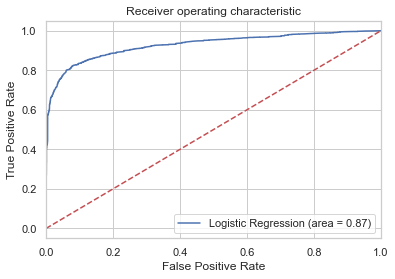

In [50]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0 ,1.0])
plt.ylabel([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.show()

По построенной кривой видно, что кривая охватывает практически все наблюдения.

Сама площадь составляет 87%, что было отмечено выше, соответсвенно работа классификатора является достаточно точной, так как болшенство наблюдений, как раз находятся под данной кривой.